In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.listdir('/content/drive/My Drive/flowers')

['sunflower', 'dandelion', 'tulip', 'rose', 'daisy']

**STEP 1: Data Preparation**

In [3]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Image dimensions and directories
IMG_SIZE = 150
FLOWER_DIRS = {
    'Daisy': '/content/drive/MyDrive/flowers/daisy',
    'Sunflower': '/content/drive/MyDrive/flowers/sunflower',
    'Tulip': '/content/drive/MyDrive/flowers/tulip',
    'Dandelion': '/content/drive/MyDrive/flowers/dandelion',
    'Rose': '/content/drive/MyDrive/flowers/rose'
}

In [4]:
# Arrays to hold image data and labels
X = []
Z = []

# Function to assign labels
def assign_label(img, flower_type):
    return flower_type

# Function to load data from directory and process images
def make_train_data(flower_type, DIR):
    for img in tqdm(os.listdir(DIR)):
        label = assign_label(img, flower_type)
        path = os.path.join(DIR, img)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X.append(np.array(img))
        Z.append(str(label))

In [5]:
# Loading data
for flower, path in FLOWER_DIRS.items():
    make_train_data(flower, path)
    print(len(X))

100%|██████████| 764/764 [00:22<00:00, 34.61it/s] 


764


100%|██████████| 733/733 [00:21<00:00, 34.73it/s] 


1497


100%|██████████| 984/984 [00:44<00:00, 22.16it/s] 


2481


100%|██████████| 1052/1052 [00:56<00:00, 18.69it/s] 


3533


100%|██████████| 784/784 [00:18<00:00, 42.02it/s] 

4317


In [6]:
# Label encoding and data splitting
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y, 5)

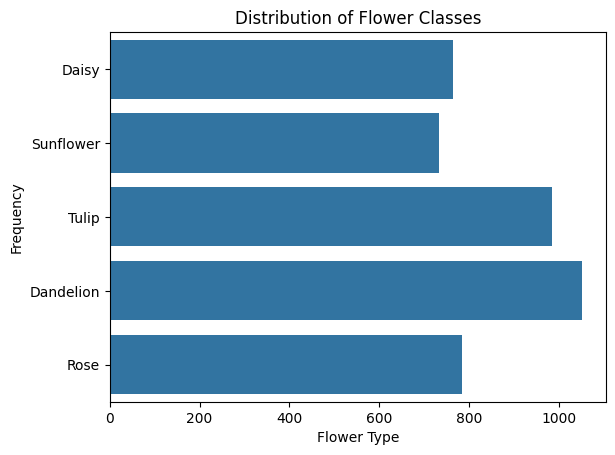

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing the distribution of flower classes
sns.countplot(Z)
plt.title('Distribution of Flower Classes')
plt.xlabel('Flower Type')
plt.ylabel('Frequency')
plt.show()


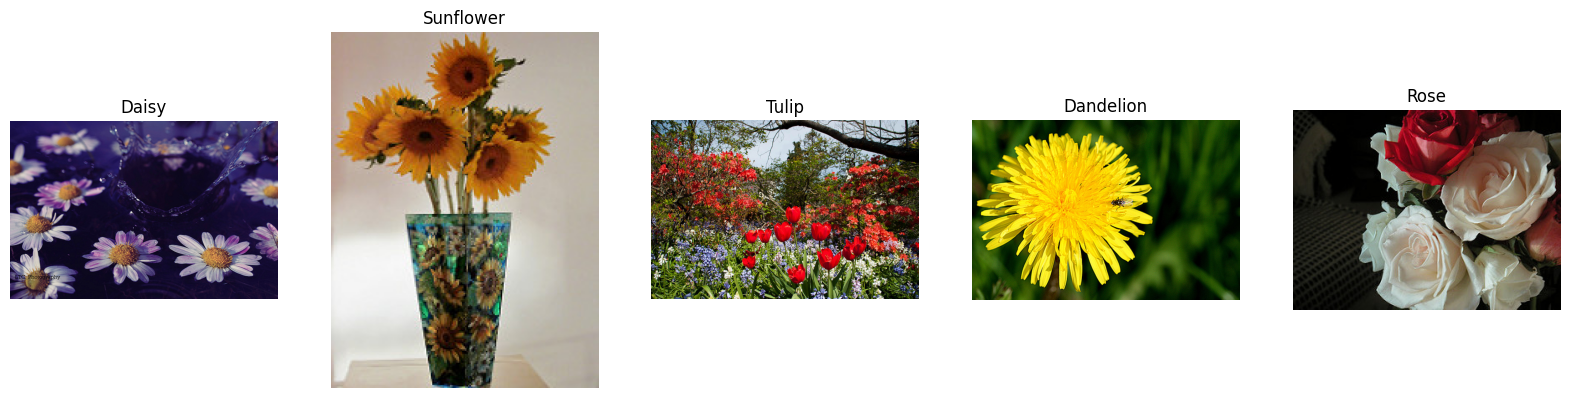

In [8]:
def plot_flower_examples():
    fig, ax = plt.subplots(1, 5, figsize=(20, 20))
    flowers = list(FLOWER_DIRS.keys())
    for i, flower in enumerate(flowers):
        path = os.path.join(FLOWER_DIRS[flower], os.listdir(FLOWER_DIRS[flower])[0])
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i].imshow(img)
        ax[i].set_title(flower)
        ax[i].axis('off')
    plt.show()

plot_flower_examples()


In [9]:
# Splitting data
X_train, X_test, Y_train, Y_test = train_test_split(np.array(X), Y, test_size=0.25,stratify=Y) #Stratifying is used to distribute all the samples uniformly in test & train dataset

In [10]:
# Checking the shapes of the datasets
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (3237, 150, 150, 3)
Y_train shape: (3237, 5)
X_test shape: (1080, 150, 150, 3)
Y_test shape: (1080, 5)


**STEP 2: : Selecting a Pre-trained Model**

In [11]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [12]:
# Load the pre-trained ResNet50 model, excluding the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

94765736/94765736 [==============================] - 1s 0us/step


**Step-3: Implementing Transfer Learning in TensorFlow**

In [13]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False
    print(layer.name, layer.trainable)

input_1 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn False
conv3_block1_1_relu False
conv3_block1_2_con

In [14]:
# Adding a global spatial average pooling layer
x = GlobalAveragePooling2D()(base_model.output)

In [15]:
# Adding a fully connected layer for classification
x = Dense(1024, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

In [16]:
# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [17]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# Model summary to verify everything is as expected
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

# Using early stopping to monitor the 'val_loss' to prevent overfitting.
# This callback is useful for stopping training when a monitored metric(val_loss) has stopped improving.
# The model has been trained using L4 GPU Runtime from upgraded Colab Pro.

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    patience=12,
    verbose=1,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, Y_train,
    validation_split=0.25,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping_monitor],
    verbose=1
)

Epoch 1/20
76/76 [==============================] - 3s 37ms/step - loss: 0.1830 - accuracy: 0.9370 - val_loss: 0.6375 - val_accuracy: 0.8531
Epoch 2/20
76/76 [==============================] - 2s 32ms/step - loss: 0.1041 - accuracy: 0.9637 - val_loss: 0.6888 - val_accuracy: 0.8543
Epoch 3/20
76/76 [==============================] - 2s 32ms/step - loss: 0.0863 - accuracy: 0.9712 - val_loss: 0.6655 - val_accuracy: 0.8543
Epoch 4/20
76/76 [==============================] - 3s 33ms/step - loss: 0.0380 - accuracy: 0.9856 - val_loss: 0.6357 - val_accuracy: 0.8531
Epoch 5/20
76/76 [==============================] - 2s 32ms/step - loss: 0.0205 - accuracy: 0.9959 - val_loss: 0.6508 - val_accuracy: 0.8802
Epoch 6/20
76/76 [==============================] - 2s 32ms/step - loss: 0.0122 - accuracy: 0.9975 - val_loss: 0.6619 - val_accuracy: 0.8741
Epoch 7/20
76/76 [==============================] - 3s 34ms/step - loss: 0.0072 - accuracy: 0.9992 - val_loss: 0.6242 - val_accuracy: 0.8790
Epoch 8/20
76

##### Step-5: Model Evaluation

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Predict classes with TensorFlow model
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true_classes = np.argmax(Y_test, axis=1)

# Calculate metrics
accuracy = accuracy_score(Y_true_classes, Y_pred_classes)
precision = precision_score(Y_true_classes, Y_pred_classes, average='weighted')
recall = recall_score(Y_true_classes, Y_pred_classes, average='weighted')
f1 = f1_score(Y_true_classes, Y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("\nDetailed classification report:")
print(classification_report(Y_true_classes, Y_pred_classes, target_names=['Daisy', 'Dandelion', 'Rose', 'Sunflower', 'Tulip']))


34/34 [==============================] - 1s 21ms/step
Accuracy: 0.88
Precision: 0.88
Recall: 0.88
F1 Score: 0.88

Detailed classification report:
              precision    recall  f1-score   support

       Daisy       0.85      0.86      0.86       191
   Dandelion       0.91      0.88      0.90       263
        Rose       0.92      0.83      0.87       196
   Sunflower       0.89      0.92      0.91       184
       Tulip       0.83      0.90      0.87       246

    accuracy                           0.88      1080
   macro avg       0.88      0.88      0.88      1080
weighted avg       0.88      0.88      0.88      1080



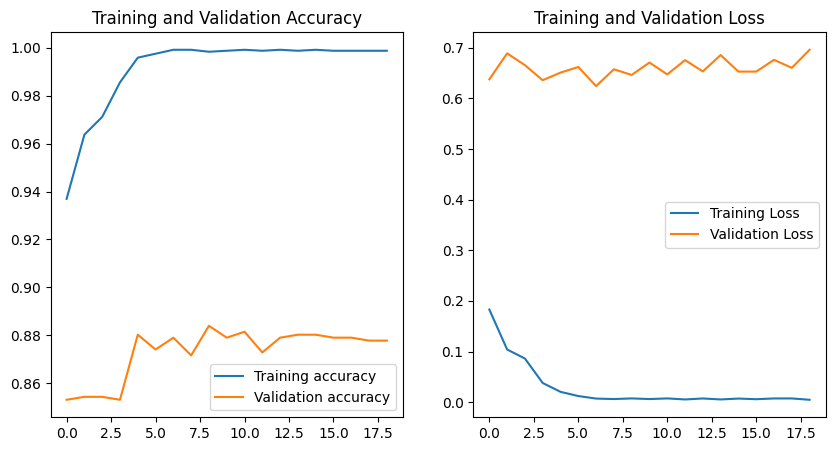

In [38]:
def plot_model_performance(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

# Call this function with the history object returned by the model.fit method
plot_model_performance(history)

34/34 [==============================] - 1s 21ms/step


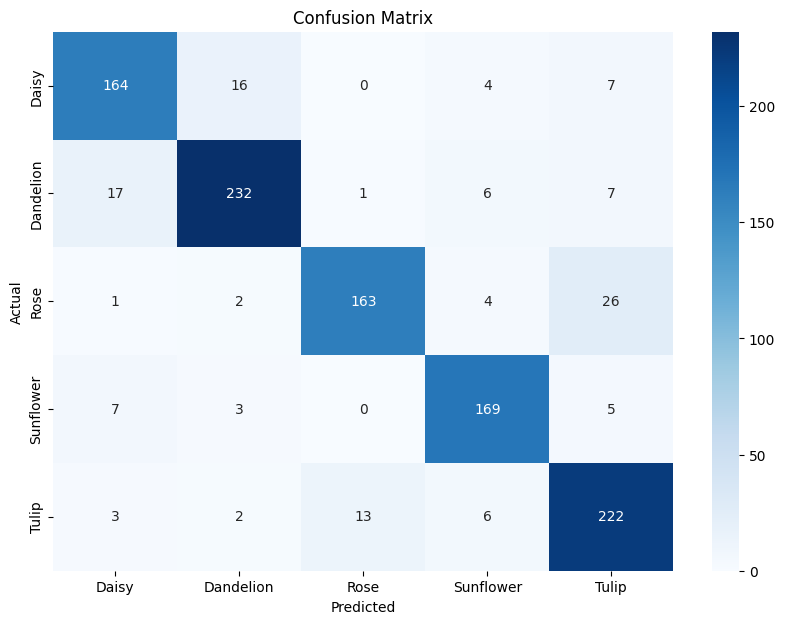

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Predict the test set
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true_classes = np.argmax(Y_test, axis=1)

# Plotting the confusion matrix
plot_confusion_matrix(Y_true_classes, Y_pred_classes, classes=['Daisy', 'Dandelion', 'Rose', 'Sunflower', 'Tulip'])


**Step 4: Implementing Transfer Learning in PyTorch**

In [40]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

In [41]:
# Load the pre-trained ResNet50 model
resnet50 = models.resnet50(pretrained=True)

# Freeze all layers in the model
for param in resnet50.parameters():
    param.requires_grad = False

# Replace the last fully connected layer to match our number of classes (5 for flowers)
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [42]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.fc.parameters(), lr=0.001)

# Transformations and DataLoader setup
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [43]:
# Convert data to tensors and create dataloaders
X_train_tensor = torch.tensor(X_train.transpose(0, 3, 1, 2)).float()  # Reshape to [N, C, H, W]
Y_train_tensor = torch.tensor(Y_train).long()

In [44]:
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [45]:
X_test_tensor = torch.tensor(X_test.transpose(0, 3, 1, 2)).float()
Y_test_tensor = torch.tensor(np.argmax(Y_test, axis=1))
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [46]:
# Training Loop
def train_model(model, criterion, optimizer, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.max(dim=1)[1])
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

# Call the training function
train_model(resnet50, criterion, optimizer)

Epoch 1/20, Loss: 0.8533724382811901
Epoch 2/20, Loss: 0.5609101308327095
Epoch 3/20, Loss: 0.47557181806540955
Epoch 4/20, Loss: 0.46911493338206234
Epoch 5/20, Loss: 0.4550925935892498
Epoch 6/20, Loss: 0.4066724266637774
Epoch 7/20, Loss: 0.39410709531283844
Epoch 8/20, Loss: 0.3795325668419109
Epoch 9/20, Loss: 0.36441002325976596
Epoch 10/20, Loss: 0.36313365399837494
Epoch 11/20, Loss: 0.35615576737943816
Epoch 12/20, Loss: 0.34543514916417645
Epoch 13/20, Loss: 0.34468010666908
Epoch 14/20, Loss: 0.3736206509319006
Epoch 15/20, Loss: 0.3034456696580438
Epoch 16/20, Loss: 0.32765041839550524
Epoch 17/20, Loss: 0.33206737757313487
Epoch 18/20, Loss: 0.2921091803148681
Epoch 19/20, Loss: 0.3005537666818675
Epoch 20/20, Loss: 0.3336861887398888


**Step-5: Model Evaluation in PyTorch**

In [47]:
import torch

# Helper function to predict classes for the whole dataset
def predict_all(model, data_loader):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

# Evaluate using the test_loader
labels, predictions = predict_all(resnet50, test_loader)

In [48]:
# Calculate metrics
accuracy = accuracy_score(labels, predictions)
precision = precision_score(labels, predictions, average='weighted')
recall = recall_score(labels, predictions, average='weighted')
f1 = f1_score(labels, predictions, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("\nDetailed classification report:")
print(classification_report(labels, predictions, target_names=['Daisy', 'Dandelion', 'Rose', 'Sunflower', 'Tulip']))

Accuracy: 0.85
Precision: 0.85
Recall: 0.85
F1 Score: 0.84

Detailed classification report:
              precision    recall  f1-score   support

       Daisy       0.88      0.84      0.86       191
   Dandelion       0.87      0.89      0.88       263
        Rose       0.85      0.73      0.79       196
   Sunflower       0.81      0.87      0.84       184
       Tulip       0.81      0.87      0.84       246

    accuracy                           0.85      1080
   macro avg       0.85      0.84      0.84      1080
weighted avg       0.85      0.85      0.84      1080

